<a href="https://colab.research.google.com/github/crux82/ganbert-pytorch/blob/main/GANBERT_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN-BERT (in Pytorch and compatible with HuggingFace)

This is a Pytorch (+ **Huggingface** transformers) implementation of the GAN-BERT model from https://github.com/crux82/ganbert. While the original GAN-BERT was an extension of BERT, this implementation can be adapted to several architectures, ranging from Roberta to Albert!

**NOTE**: given that this implementation is different from the original one in Tensorflow, some results can be slighty different.


Let's GO!

Required Imports.

In [1]:
#!pip install transformers==4.3.2
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece

##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [2]:
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt

In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


### Input Parameters


In [4]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size = 64

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-6
learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 1000
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

#model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name = "all-MiniLM-L6-v2"
#model_name = "all-mpnet-base-v2"
#model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
model_name = 'sentence-transformers/paraphrase-MiniLM-L6-v2'


#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
! git clone https://github.com/crux82/ganbert

#  NOTE: in this setting 50 classes are involved
labeled_file = "./ganbert/data/labeled.tsv"
unlabeled_file = "./ganbert/data/unlabeled.tsv"
test_filename = "./ganbert/data/test.tsv"

label_list = ["UNK_UNK","ABBR_abb", "ABBR_exp", "DESC_def", "DESC_desc", 
              "DESC_manner", "DESC_reason", "ENTY_animal", "ENTY_body", 
              "ENTY_color", "ENTY_cremat", "ENTY_currency", "ENTY_dismed", 
              "ENTY_event", "ENTY_food", "ENTY_instru", "ENTY_lang", 
              "ENTY_letter", "ENTY_other", "ENTY_plant", "ENTY_product", 
              "ENTY_religion", "ENTY_sport", "ENTY_substance", "ENTY_symbol", 
              "ENTY_techmeth", "ENTY_termeq", "ENTY_veh", "ENTY_word", "HUM_desc", 
              "HUM_gr", "HUM_ind", "HUM_title", "LOC_city", "LOC_country", 
              "LOC_mount", "LOC_other", "LOC_state", "NUM_code", "NUM_count", 
              "NUM_date", "NUM_dist", "NUM_money", "NUM_ord", "NUM_other", 
              "NUM_perc", "NUM_period", "NUM_speed", "NUM_temp", "NUM_volsize", 
              "NUM_weight"]

fatal: destination path 'ganbert' already exists and is not an empty directory.


Load the Tranformer Model

In [5]:
# transformer = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)
model_transformer = SentenceTransformer(model_name)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

loading configuration file /Users/harrison.cook/.cache/torch/sentence_transformers/sentence-transformers_paraphrase-MiniLM-L6-v2/config.json
Model config BertConfig {
  "_name_or_path": "/Users/harrison.cook/.cache/torch/sentence_transformers/sentence-transformers_paraphrase-MiniLM-L6-v2/",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /Users/harrison.cook/.cache/torch/sentence_transformers/sentence-transformers_paraphrase-MiniLM-L6-

Function required to load the dataset

In [6]:
def get_qc_examples(input_file):
  """Creates examples for the training and dev sets."""
  examples = []

  with open(input_file, 'r') as f:
      contents = f.read()
      file_as_list = contents.splitlines()
      for line in file_as_list[1:]:
          split = line.split(" ")
          question = ' '.join(split[1:])

          text_a = question
          inn_split = split[0].split(":")
          label = inn_split[0] + "_" + inn_split[1]
          examples.append((text_a, label))
      f.close()

  return examples

**Load** the input QC dataset (fine-grained)

In [7]:
#Load the examples
labeled_examples = get_qc_examples(labeled_file)
unlabeled_examples = get_qc_examples(unlabeled_file)
test_examples = get_qc_examples(test_filename)

Functions required to convert examples into Dataloader

In [8]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = model_transformer.encode(text[0])
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Convert the input examples into DataLoader

In [9]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

/var/folders/11/86f3z1k93pq0q7qb52tszh980000gn/T/ipykernel_11583/454584618.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  input_ids = torch.tensor(input_ids)
/var/folders/11/86f3z1k93pq0q7qb52tszh980000gn/T/ipykernel_11583/454584618.py:49: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


We define the Generator and Discriminator as discussed in https://www.aclweb.org/anthology/2020.acl-main.191/

In [10]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

We instantiate the Discriminator and Generator

In [11]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
#config = AutoConfig.from_pretrained(model_name)
#hidden_size = int(config.hidden_size)
hidden_size = 384
# Define the number and width of hidden layers
hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

Let's go with the training procedure

In [12]:
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
#transformer_vars = [i for i in transformer.parameters()]
#d_vars = transformer_vars + [v for v in discriminator.parameters()]
d_vars = [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

accuracy_array=[]

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    #transformer.train() 
    generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        #if step % print_each_n_step == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)

        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_label_mask = batch[2].to(device)

        real_batch_size = b_input_ids.shape[0]
     
        # Encode real data in the Transformer
        #model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        #hidden_states = model_outputs[-1]
        hidden_states = b_input_ids
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        gen_rep = generator(noise)

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_d.step()
          scheduler_g.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    #transformer.eval() #maybe redundant
    discriminator.eval()
    generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        #b_input_mask = batch[1].to(device)
        b_labels = batch[1].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            #model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            #hidden_states = model_outputs[-1]
            hidden_states=b_input_ids
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )
    
    accuracy_array.append(test_accuracy)


======== Epoch 1 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20 

  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 4.962
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.018
  Test Loss: 3.913
  Test took: 0:00:00

======== Epoch 3 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch  

  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88

  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76

  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59

  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33

  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.737
  Average training loss discriminator: 4.425
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.266
  Test Loss: 3.763
  Test took: 0:00:00

======== Epoch 16 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch 

  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.734
  Average training loss discriminator: 4.381
  Training epcoh too

  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88

  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71

  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55

  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40

  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25

  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28

  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.725
  Average training loss discriminator: 3.999
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.292
  Test Loss: 3.547
  Test took: 0:00:00

======== Epoch 31 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch 

  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.723
  Average training loss discriminator: 3.950
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.302
  Test Loss: 3.516
  Test took: 0:00:00

======== Epoch 33 / 1000 ========
Training...
  Batch 

  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87

  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78

  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69

  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57

  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.717
  Average training loss discriminator: 3.540
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.320
  Test Loss: 3.317
  Test took: 0:00:00

======== Epoch 46 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch 

  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.714
  Average training

  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80

  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63

  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50

  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36

  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33

  Accuracy: 0.338
  Test Loss: 3.160
  Test took: 0:00:00

======== Epoch 59 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  

  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 3.141
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.344
  Test Loss: 3.140
  Test took: 0:00:00

======== Epoch 61 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch 

  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 3.075
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.352
  Test Loss: 3.121
  Test took: 0:00:00

=======

  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80

  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68

  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56

  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43

  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34

  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22

  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22

  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.710
  Average training loss discriminator: 2.801
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.374
  Test Loss: 3.012
  Test took: 0:00:00

======== Epoch 78 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch 

  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89

  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73

  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62

  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23

  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.710
  Average training loss discriminator: 2.582
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.404
  Test Loss: 2.944
  Test took: 0:00:00

======== Epoch 91 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch 

  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90

  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72

  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55

  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40

  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22

  Accuracy: 0.424
  Test Loss: 2.901
  Test took: 0:00:00

======== Epoch 102 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
 

  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 2.377
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.424
  Test Loss: 2.895
  Test took: 0:00:00

======== Epoch 104 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.710
  Average training

  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91

  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72

  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68

  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.710
  Average training loss discriminator: 2.212
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.432
  Test Loss: 2.859
  Test took: 0:00:00

======== Epoch 119 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.709
  Average training loss discriminator: 2.165
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.436
  Test Loss: 2.855
  Test took: 0:00:00

======== Epoch 121 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90

  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74

  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56

  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54

  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:01.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52

  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.710
  Average training loss discriminator: 1.991
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.434
  Test Loss: 2.834
  Test took: 0:00:00

======== Epoch 136 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 1.987
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.434
  Test Loss: 2.833
  Test took: 0:00:00

======== Epoch 138 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81

  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64

  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22

  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.710
  Average training loss discriminator: 1.806
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.438
  Test Loss: 2.823
  Test took: 0:00:00

======== Epoch 151 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 1.777
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.438
  Test Loss: 2.823
  Test took: 0:00:00

======== Epoch 153 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85

  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75

  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65

  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56

  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46

  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37

  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24

  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 1.664
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.442
  Test Loss: 2.819
  Test took: 0:00:00

======== Epoch 168 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 1.615
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.442
  Test Loss: 2.820
  Test took: 0:00:00

======== Epoch 170 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89

  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80

  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73

  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29


  Average training loss generetor: 0.711
  Average training loss discriminator: 1.487
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.448
  Test Loss: 2.829
  Test took: 0:00:00

======== Epoch 185 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 1.436
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.448
  Test Loss: 2.830
  Test took: 0:00:00

======== Epoch 187 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training

  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84

  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76

  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68

  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38

  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Accuracy: 0.448
  Test Loss: 2.845
  Test took: 0:00:00

======== Epoch 206 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
 

  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 1.298
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.448
  Test Loss: 2.846
  Test took: 0:00:00

======== Epoch 208 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89

  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76

  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 1.223
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.446
  Test Loss: 2.859
  Test took: 0:00:00

======== Epoch 221 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 1.195
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.448
  Test Loss: 2.861
  Test took: 0:00:00

======== Epoch 223 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 1.200
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.448
 

  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82

  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72

  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61

  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48

  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39

  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30

  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 1.107
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.446
  Test Loss: 2.881
  Test took: 0:00:00

======== Epoch 238 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average tr

  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74

  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60

  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30

  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.713
  Average training loss discriminator: 1.053
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.448
  Test Loss: 2.901
  Test took: 0:00:00

======== Epoch 251 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91

  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74

  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59

  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.713
  Average training loss discriminator: 0.999
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.452
  Test Loss: 2.920
  Test took: 0:00:00

======== Epoch 264 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.988
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.452
  Test Loss: 2.922
  Test took: 0:00:00

======== Epoch 266 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82

  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69

  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33

  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36

  Accuracy: 0.452
  Test Loss: 2.945
  Test took: 0:00:00

======== Epoch 281 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
 

  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.713
  Average training loss discriminator: 0.923
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.452
  Test Loss: 2.948
  Test took: 0:00:00

======== Epoch 283 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average tr

  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76

  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.901
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.450
  Test Loss: 2.967
  Test took: 0:00:00

======== Epoch 294 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.713
  Average training

  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77

  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65

  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51

  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37

  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24

  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.867
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.448
  Test Loss: 2.992
  Test took: 0:00:00

======== Epoch 307 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89

  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74

  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60

  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.713
  Average training loss discriminator: 0.841
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.446
  Test Loss: 3.013
  Test took: 0:00:00

======== Epoch 318 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88

  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75

  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63

  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.820
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.446
  Test Loss: 3.033
  Test took: 0:00:00

======== Epoch 329 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.713
  Average training loss discriminator: 0.823
  Training epcoh too

  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82

  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67

  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58

  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46

  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.804
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
  Test Loss: 3.068
  Test took: 0:00:00

======== Epoch 346 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.800
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.442
  Test Loss: 3.072
  Test took: 0:00:00

=======

  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82

  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68

  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55

  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.788
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
  Test Loss: 3.091
  Test took: 0:00:00

======== Epoch 359 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.787
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
 

  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81

  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64

  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46

  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.713
  Average training loss discriminator: 0.771
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.434
  Test Loss: 3.123
  Test took: 0:00:00

======== Epoch 378 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86

  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69

  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57

  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44

  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25

  Accuracy: 0.432
  Test Loss: 3.147
  Test took: 0:00:00

======== Epoch 389 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
 

  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.713
  Average training loss discriminator: 0.758
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.432
  Test Loss: 3.153
  Test took: 0:00:00

======== Epoch 391 / 1000 ========
Training...
  Batch

  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80

  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70

  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60

  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:01.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52

  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:01.
  Batch    44  of     92.    Elapsed: 0:00:01.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47

  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.752
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.432
  Test Loss: 3.187
  Test took: 0:00:00

======== Epoch 408 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.751
  Training epcoh too

  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78

  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60

  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46

  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30

  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 0.747
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.430
  Test Loss: 3.212
  Test took: 0:00:00

======== Epoch 419 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.744
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.428
 

  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 0.745
  Training epcoh too

  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76

  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 0.739
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.430
  Test Loss: 3.237
  Test took: 0:00:00

======== Epoch 432 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.712
  Average training loss discriminator: 0.741
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.428
  Test Loss: 3.242
  Test took: 0:00:00

======== Epoch 434 / 1000 ========
Training...
  Batch

  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85

  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73

  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.711
  Average training loss discriminator: 0.735
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.428
  Test Loss: 3.273
  Test took: 0:00:00

======== Epoch 449 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89

  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74

  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64

  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49

  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34

  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25

  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.710
  Average training loss discriminator: 0.730
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.426
  Test Loss: 3.299
  Test took: 0:00:00

======== Epoch 462 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.710
  Average training loss discriminator: 0.730
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.426
  Test Loss: 3.305
  Test took: 0:00:00

======== Epoch 464 / 1000 ========
Training...
  Batch

  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83

  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68

  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52

  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36

  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23

  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25

  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.710
  Average training loss discriminator: 0.728
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.428
  Test Loss: 3.331
  Test took: 0:00:00

======== Epoch 477 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.710
  Average training loss discriminator: 0.727
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.428
  Test Loss: 3.334
  Test took: 0:00:00

======== Epoch 479 / 1000 ========
Training...
  Batch

  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83

  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72

  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57

  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41

  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.709
  Average training loss discriminator: 0.723
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.426
  Test Loss: 3.380
  Test took: 0:00:00

======== Epoch 498 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.708
  Average training loss discriminator: 0.724
  Training epcoh too

  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80

  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64

  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52

  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37

  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37

  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.708
  Average training loss discriminator: 0.722
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.428
  Test Loss: 3.410
  Test took: 0:00:00

======== Epoch 515 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.707
  Average training loss discriminator: 0.721
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.428
  Test Loss: 3.413
  Test took: 0:00:00

======== Epoch 517 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.708
  Average training loss discriminator: 0.721
  Training epcoh too

  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77

  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63

  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48

  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36

  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36

  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38

  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23

  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.706
  Average training loss discriminator: 0.719
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.426
  Test Loss: 3.453
  Test took: 0:00:00

======== Epoch 538 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89

  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75

  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57

  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41

  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.707
  Average training loss discriminator: 0.717
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.426
  Test Loss: 3.479
  Test took: 0:00:00

======== Epoch 551 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90

  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75

  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:00.
  Batch    49  of     92.    Elapsed: 0:00:00.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64

  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:01.
  Batch    44  of     92.    Elapsed: 0:00:01.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51

  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36

  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39

  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25

  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.706
  Average training loss discriminator: 0.716
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.428
  Test Loss: 3.504
  Test took: 0:00:00

======== Epoch 566 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88

  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74

  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62

  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35


  Average training loss generetor: 0.706
  Average training loss discriminator: 0.714
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.430
  Test Loss: 3.528
  Test took: 0:00:00

======== Epoch 579 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.706
  Average training loss discriminator: 0.714
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.430
  Test Loss: 3.532
  Test took: 0:00:00

======== Epoch 581 / 1000 ========
Training...
  Batch

  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82

  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69

  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62

  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52

  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41

  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25

  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.705
  Average training loss discriminator: 0.713
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.430
  Test Loss: 3.550
  Test took: 0:00:00

======== Epoch 594 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.705
  Average training loss discriminator: 0.713
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.428
 

  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86

  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76

  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62

  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47

  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.705
  Average training loss discriminator: 0.712
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.428
  Test Loss: 3.566
  Test took: 0:00:00

======== Epoch 609 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90

  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74

  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59

  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44

  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35

  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24

  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.704
  Average training loss discriminator: 0.711
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.430
  Test Loss: 3.584
  Test took: 0:00:00

======== Epoch 622 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.704
  Average training loss discriminator: 0.711
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.430
  Test Loss: 3.587
  Test took: 0:00:00

======== Epoch 624 / 1000 ========
Training...
  Batch

  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78

  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30

  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33

  Accuracy: 0.432
  Test Loss: 3.602
  Test took: 0:00:00

======== Epoch 635 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
 

  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.704
  Average training loss discriminator: 0.710
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.432
  Test Loss: 3.604
  Test took: 0:00:00

=======

  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.704
  Average training

  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75

  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63

  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28

  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23

  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23

  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.709
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.432
  Test Loss: 3.637
  Test took: 0:00:00

======== Epoch 664 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.710
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.432
  Test Loss: 3.641
  Test took: 0:00:00

======== Epoch 666 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86

  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68

  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:01.
  Batch    44  of     92.    Elapsed: 0:00:01.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30

  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.708
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.432
  Test Loss: 3.652
  Test took: 0:00:00

======== Epoch 677 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.708
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.432
  Test Loss: 3.654
  Test took: 0:00:00

======== Epoch 679 / 1000 ========
Training...
  Batch

  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.703
  Average training loss discriminator: 0.708
  Training epcoh too

  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86

  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80

  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77

  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71

  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56

  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51

  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43

  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39

  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.707
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.434
  Test Loss: 3.676
  Test took: 0:00:00

======== Epoch 702 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average tr

  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76

  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65

  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53

  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.706
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.434
  Test Loss: 3.690
  Test took: 0:00:00

======== Epoch 715 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87

  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86

  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84

  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80

  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74

  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:01.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56

  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55

  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38

  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23

  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.706
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.430
  Test Loss: 3.706
  Test took: 0:00:00

======== Epoch 734 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average tr

  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77

  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58

  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.705
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.436
  Test Loss: 3.715
  Test took: 0:00:00

======== Epoch 745 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.705
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.436
  Test Loss: 3.717
  Test took: 0:00:00

======== Epoch 747 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90

  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88

  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75

  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66

  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56

  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47

  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Accuracy: 0.436
  Test Loss: 3.728
  Test took: 0:00:00

======== Epoch 764 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
 

  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.705
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.436
  Test Loss: 3.729
  Test took: 0:00:00

======== Epoch 766 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91

  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74

  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:00.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62

  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55

  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43

  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28

  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.704
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.436
  Test Loss: 3.741
  Test took: 0:00:00

======== Epoch 779 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88

  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72

  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58

  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48

  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22

  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.704
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
  Test Loss: 3.754
  Test took: 0:00:00

======== Epoch 794 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88

  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72

  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56

  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.704
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
  Test Loss: 3.762
  Test took: 0:00:00

======== Epoch 805 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.703
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
 

  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79

  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64

  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25

  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.703
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
  Test Loss: 3.773
  Test took: 0:00:00

======== Epoch 822 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.702
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
  Test Loss: 3.776
  Test took: 0:00:00

======== Epoch 824 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90

  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79

  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70

  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60

  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.702
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
  Test Loss: 3.783
  Test took: 0:00:00

======== Epoch 839 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.702
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
  Test Loss: 3.784
  Test took: 0:00:00

======== Epoch 841 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90

  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72

  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56

  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41

  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27

  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.702
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.438
  Test Loss: 3.790
  Test took: 0:00:00

======== Epoch 852 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.702
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.438
 

  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80

  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66

  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63

  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25

  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.702
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.446
  Test Loss: 3.802
  Test took: 0:00:00

======== Epoch 869 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average tr

  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77

  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63

  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61

  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.702
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.446
  Test Loss: 3.812
  Test took: 0:00:00

======== Epoch 882 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.701
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.446
  Test Loss: 3.813
  Test took: 0:00:00

======== Epoch 884 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88

  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77

  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60

  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44

  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28

  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.701
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.450
  Test Loss: 3.819
  Test took: 0:00:00

======== Epoch 895 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.701
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.450
  Test Loss: 3.818
  Test took: 0:00:00

======== Epoch 897 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91

  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81

  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70

  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61

  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49

  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36

  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24

  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26

  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.701
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.452
  Test Loss: 3.826
  Test took: 0:00:00

======== Epoch 914 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.701
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.452
  Test Loss: 3.826
  Test took: 0:00:00

======== Epoch 916 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89

  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77

  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68

  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:00.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60

  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51

  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22

  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.700
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.454
  Test Loss: 3.831
  Test took: 0:00:00

======== Epoch 933 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.701
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.456
 

  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average tr

  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73

  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57

  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40

  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40

  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28

  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.700
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.458
  Test Loss: 3.839
  Test took: 0:00:00

======== Epoch 948 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.700
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.458
 

  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77

  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:00.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60

  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31

  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32

  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33

  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30

  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30

  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24

  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22

  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21

  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22

  Accuracy: 0.458
  Test Loss: 3.846
  Test took: 0:00:00

======== Epoch 977 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
 

  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.700
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.458
  Test Loss: 3.847
  Test took: 0:00:00

======== Epoch 979 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.700
  Training epcoh too

  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76

  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:00.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61

  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:00.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54

  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43

  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch    15  of     92.    Elapsed: 0:00:00.
  Batch    16  of     92.    Elapsed: 0:00:00.
  Batch    17  of     92.    Elapsed: 0:00:00.
  Batch    18  of     92.    Elapsed: 0:00:00.
  Batch    19  of     92.    Elapsed: 0:00:00.
  Batch    20  of     92.    Elapsed: 0:00:00.
  Batch    21  of     92.    Elapsed: 0:00:00.
  Batch    22  of     92.    Elapsed: 0:00:00.
  Batch    23  of     92.    Elapsed: 0:00:00.
  Batch    24  of     92.    Elapsed: 0:00:00.
  Batch    25  of     92.    Elapsed: 0:00:00.
  Batch    26  of     92.    Elapsed: 0:00:00.
  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29

  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.700
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.462
  Test Loss: 3.849
  Test took: 0:00:00

======== Epoch 992 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch     3  of     92.    Elapsed: 0:00:00.
  Batch     4  of     92.    Elapsed: 0:00:00.
  Batch     5  of     92.    Elapsed: 0:00:00.
  Batch     6  of     92.    Elapsed: 0:00:00.
  Batch     7  of     92.    Elapsed: 0:00:00.
  Batch     8  of     92.    Elapsed: 0:00:00.
  Batch     9  of     92.    Elapsed: 0:00:00.
  Batch    10  of     92.    Elapsed: 0:00:00.
  Batch    11  of     92.    Elapsed: 0:00:00.
  Batch    12  of     92.    Elapsed: 0:00:00.
  Batch    13  of     92.    Elapsed: 0:00:00.
  Batch    14  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85  of     92.    Elapsed: 0:00:01.
  Batch    86  of     92.    Elapsed: 0:00:01.
  Batch    87  of     92.    Elapsed: 0:00:01.
  Batch    88  of     92.    Elapsed: 0:00:01.
  Batch    89  of     92.    Elapsed: 0:00:01.
  Batch    90  of     92.    Elapsed: 0:00:01.
  Batch    91  of     92.    Elapsed: 0:00:01.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.700
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.462
  Test Loss: 3.851
  Test took: 0:00:00

======== Epoch 994 / 1000 ========
Training...
  Batch     0  of     92.    Elapsed: 0:00:00.
  Batch     1  of     92.    Elapsed: 0:00:00.
  Batch     2  of     92.    Elapsed: 0:00:00.
  Batch

  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67  of     92.    Elapsed: 0:00:01.
  Batch    68  of     92.    Elapsed: 0:00:01.
  Batch    69  of     92.    Elapsed: 0:00:01.
  Batch    70  of     92.    Elapsed: 0:00:01.
  Batch    71  of     92.    Elapsed: 0:00:01.
  Batch    72  of     92.    Elapsed: 0:00:01.
  Batch    73  of     92.    Elapsed: 0:00:01.
  Batch    74  of     92.    Elapsed: 0:00:01.
  Batch    75  of     92.    Elapsed: 0:00:01.
  Batch    76  of     92.    Elapsed: 0:00:01.
  Batch    77  of     92.    Elapsed: 0:00:01.
  Batch    78  of     92.    Elapsed: 0:00:01.
  Batch    79  of     92.    Elapsed: 0:00:01.
  Batch    80  of     92.    Elapsed: 0:00:01.
  Batch    81  of     92.    Elapsed: 0:00:01.
  Batch    82  of     92.    Elapsed: 0:00:01.
  Batch    83  of     92.    Elapsed: 0:00:01.
  Batch    84  of     92.    Elapsed: 0:00:01.
  Batch    85

  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48  of     92.    Elapsed: 0:00:01.
  Batch    49  of     92.    Elapsed: 0:00:01.
  Batch    50  of     92.    Elapsed: 0:00:01.
  Batch    51  of     92.    Elapsed: 0:00:01.
  Batch    52  of     92.    Elapsed: 0:00:01.
  Batch    53  of     92.    Elapsed: 0:00:01.
  Batch    54  of     92.    Elapsed: 0:00:01.
  Batch    55  of     92.    Elapsed: 0:00:01.
  Batch    56  of     92.    Elapsed: 0:00:01.
  Batch    57  of     92.    Elapsed: 0:00:01.
  Batch    58  of     92.    Elapsed: 0:00:01.
  Batch    59  of     92.    Elapsed: 0:00:01.
  Batch    60  of     92.    Elapsed: 0:00:01.
  Batch    61  of     92.    Elapsed: 0:00:01.
  Batch    62  of     92.    Elapsed: 0:00:01.
  Batch    63  of     92.    Elapsed: 0:00:01.
  Batch    64  of     92.    Elapsed: 0:00:01.
  Batch    65  of     92.    Elapsed: 0:00:01.
  Batch    66  of     92.    Elapsed: 0:00:01.
  Batch    67

  Batch    27  of     92.    Elapsed: 0:00:00.
  Batch    28  of     92.    Elapsed: 0:00:00.
  Batch    29  of     92.    Elapsed: 0:00:00.
  Batch    30  of     92.    Elapsed: 0:00:00.
  Batch    31  of     92.    Elapsed: 0:00:00.
  Batch    32  of     92.    Elapsed: 0:00:00.
  Batch    33  of     92.    Elapsed: 0:00:00.
  Batch    34  of     92.    Elapsed: 0:00:00.
  Batch    35  of     92.    Elapsed: 0:00:00.
  Batch    36  of     92.    Elapsed: 0:00:00.
  Batch    37  of     92.    Elapsed: 0:00:00.
  Batch    38  of     92.    Elapsed: 0:00:00.
  Batch    39  of     92.    Elapsed: 0:00:00.
  Batch    40  of     92.    Elapsed: 0:00:00.
  Batch    41  of     92.    Elapsed: 0:00:00.
  Batch    42  of     92.    Elapsed: 0:00:00.
  Batch    43  of     92.    Elapsed: 0:00:00.
  Batch    44  of     92.    Elapsed: 0:00:00.
  Batch    45  of     92.    Elapsed: 0:00:01.
  Batch    46  of     92.    Elapsed: 0:00:01.
  Batch    47  of     92.    Elapsed: 0:00:01.
  Batch    48

In [13]:
for stat in training_stats:
  print(stat)

print("\nTraining complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

{'epoch': 1, 'Training Loss generator': 0.07896368827103921, 'Training Loss discriminator': 7.126982859943224, 'Valid. Loss': 3.9221434593200684, 'Valid. Accur.': 0.018, 'Training Time': '0:00:01', 'Test Time': '0:00:00'}
{'epoch': 2, 'Training Loss generator': 0.7119095011249833, 'Training Loss discriminator': 4.961505039878514, 'Valid. Loss': 3.912590742111206, 'Valid. Accur.': 0.018, 'Training Time': '0:00:01', 'Test Time': '0:00:00'}
{'epoch': 3, 'Training Loss generator': 0.7854903845683389, 'Training Loss discriminator': 4.7248340929331984, 'Valid. Loss': 3.90181303024292, 'Valid. Accur.': 0.032, 'Training Time': '0:00:01', 'Test Time': '0:00:00'}
{'epoch': 4, 'Training Loss generator': 0.7712675870760627, 'Training Loss discriminator': 4.724403920380966, 'Valid. Loss': 3.8908214569091797, 'Valid. Accur.': 0.044, 'Training Time': '0:00:01', 'Test Time': '0:00:00'}
{'epoch': 5, 'Training Loss generator': 0.7634532153606415, 'Training Loss discriminator': 4.7004765323970625, 'Valid

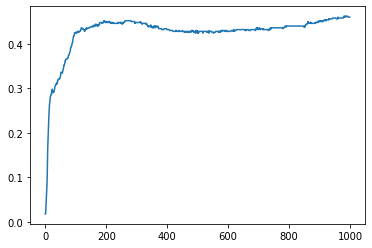

In [14]:
plt.plot(accuracy_array)

In [15]:
print(max(accuracy_array))
#all-MiniLM-L6-v2 = 0.466
#all-mpnet-base-v2 = 0.502
#sentence-transformers/bert-base-nli-mean-tokens = 0.4
#sentence-transformers/paraphrase-MiniLM-L6-v2 = 0.462

0.462


In [16]:
print(accuracy_array[-1])

0.46
